# Convolutional neural network

In the previous unit we have learned how to define a multi-playered neural network using class definition, but those networks were generic, and not specialized for computer vision tasks. In this unit we will learn about **Convolutional Neural Network (CNNs)**, which are specifically designed for computer vision. 

Computer vision is different from generic classification, because when we are trying to find a certain object in the picture, we are scanning the image looking for some specific **patterns** and their combinations. For example, when looking for a cat, we first may look for horizontal lines, which can form whiskers, and certain combination of whiskers can tell us that it is actually a picture of a cat. Relative position and presence of certain patterns is important, and not their exact position on the image. 

TO extract patterns, we will use the notion of **convolutional filters**. But first, let us load all dependencies and functions that we have defined in the previous units.

In [1]:
import torch
from torch import nn 
from torch.utils.data import DataLoader
import numpy as np 
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchinfo import summary
import torchvision


## Convolutional filters

Convolutional filters are small windows that run over each pixel of the image and compute weighted average of the neighboring pixels.

The are defined by matrices of weight coefficients. Let's see the examples of applying two different convolutional filters over our MNIST handwritten digits:


First filter is called a **vertical edge filter**, and it is defined by the following matrix:
$$
\left(
    \begin{matrix}
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
    \end{matrix}
\right)
$$
When this filter goes over relatively uniform pixel field, all values add up to 0. However, when it encounters a vertical edge in the image, high spike value is generated. That's why in the images above you can see vertical edges represented by high and low values, while horizontal edges are averaged out.

An opposite thing happens when we apply horizontal edge filter - horizontal lines are amplified, and vertical are averaged out.

In classical computer vision, multiple filters were applied to the image to generate features, which then were used by machine learning algorithm to build a classifier. However, in deep learning we construct networks that **learn** best convolutional filters to solve classification problem.

To do that, we introduce **convolutional layers**.

## Convolutional layers

Convolutional layers are defined using **nn.Conv2d** construction. We need to specify the following:

* **in_channels** - number of input channels. In our case we are dealing with a grayscale image, thus number of input channels is 1.
* **out_channels** - number of filters to use. We will use 9 different filters, which will give the network plenty of opportunities to explore which filters work best for our scenario. 
* **kernel_size** is the size of the sliding window. Usually 3x3 or 5x5 are used. 
Simplest CNN will containe one convolutional layer. Given the input size 28x28, after applying nine 5x5 filters we will end up with a tensor of 9x24x24(Because there are only 24 position where a sliding interval of length 5 can fit into 28 pixels).

After convolution, we flatten 9x24x24 tensor into one vector of size 5184(9x24x24) and then add linear layer, to produce 10 classes. We also use **ReLU** activation function in between layers.
 


In [2]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=1, out_channels=9, kernel_size=(5, 5))
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(9*24*24, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, X):
        X = nn.functional.relu(self.conv(X))
        X = self.flatten(X)
        logits = self.linear_relu_stack(X)
        return logits

net  = OneConv()
summary(net, input_size=(1,1,28,28))


Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  --                        --
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Sequential: 1-3                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 10]                   51,850
│    └─LogSoftmax: 2-2                   [1, 10]                   --
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

We can see that this network contains around 50K trainable parameters, compared to around 80k in fully-connected multi-layered networks. This allows us to achieve good results even on smaller datasets, because convolutional networks generalize much better.

C:\Users\duong\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


We use cuda


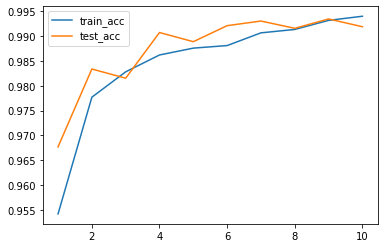

In [3]:
training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
      root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

training_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'We use {device}')

net.to(device)

def training_epoch(model, dataloader, loss_fn, optimizer):
    total_loss, acc = 0,0
    data_size = len(dataloader.dataset)
    model.train()
    for (X,y) in dataloader:
        (X,y) = (X.to(device), y.to(device))
        out = model(X)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, y_pred = torch.max(out, dim=1)
        total_loss += loss_fn(out, y).item()
        acc += (y_pred == y).type(torch.float).sum().item()
    return total_loss/(data_size), acc/(data_size)

def valid_epoch(model, dataloader, loss_fn):
    """[This function allows to evaluate]

    Args:
        model ([type]): [description]
        dataloader ([type]): [description]
        loss_fn ([type]): [description]

    Returns:
        [type]: [description]
    """
    data_size = len(dataloader.dataset)
    loss, acc = 0,0
    model.eval()
    for X,y in dataloader:
        X,y = X.to(device), y.to(device)
        out = model(X)
        _, y_pred = torch.max(out, dim=1)
        loss += loss_fn(out, y).item()
        acc += (y_pred == y).type(torch.float).sum().item()
        
    return loss/(data_size), acc/(data_size)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

train_hist = []
test_hist = []

# Try to turn our network for 10 times 
for t in range(10):
    train_hist.append(training_epoch(net, training_dataloader, loss_fn, optimizer))
    with torch.no_grad():
        test_hist.append(valid_epoch(net, test_dataloader, loss_fn))
train_loss = [i[0] for i in train_hist]
train_acc = [i[1] for i in train_hist]
test_loss = [i[0] for i in test_hist]
test_acc = [i[1] for i in test_hist]

# Plot accuracy over 10 times
plt.figure()
plt.plot([x+1 for x in range(10)], train_acc)
plt.plot([x+1 for x in range(10)], test_acc)
plt.legend(['train_acc', 'test_acc'])
plt.show()



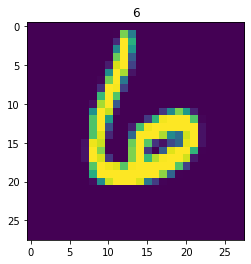

In [4]:
k = torch.randint(0, len(training_data),())

X = training_data[k][0].to(device)
y = torch.tensor(training_data[k][1]).to(device)

def predict(X, model):
    X = torch.reshape(X, (1,1,28,28))
    out = model.to(device)(X)
    _,y_pred = torch.max(out, 1)
    return y_pred.item()

def show_img(X, model):
    plt.figure()
    plt.imshow(X.to('cpu').view(28,28))
    plt.title(predict(X, model))
    plt.show()

show_img(X, net)

## Multi-layered CNNs and pooling layers

First convolutional layers looks for primitive patterns, such as horizontal or vertical line, but we can apply further convolutional layers on top of them to look for higher-level patterns, such as primitive shapes. Then more convolutional layers can combine those shapes into some parts of the pickture, up to the final object that we are trying to classify.

When doing so, we may also apply one trick: reducing the spatial size of the image. One we have detected there is a horizontal stoke within sliding 3x3 window, it is not so important at which exact pixel it occurred. Thus we can "scale down: the size of the image, which is done using one of the **pooling layers**:

* **Average Pooling** takes a sliding window (for example, 2x2 pixels) and compute an average of values within the window
* **Max Pooling** replace the window with the maximum value. The idea behind max pooling is to detect a presence of a certain pattern within the sliding window.
  
Thus, in a typical CNN there would be several convolutional layers, with pooling layers in between them to decrease dimensions of the image. We woould also increase the number of filters, beause as patterns become more advanced - there are more possible interesting combinations that we need to be looking for.

![An image showing several convolutional layers with pooling layers.](https://docs.microsoft.com/en-us/learn/modules/intro-computer-vision-pytorch/images/cnn-pyramid.png)

Because of decreasing spatial dimensions and increasing feature/filters dimensions, this architecture is also called **pyramid architecture**


In [5]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.stack = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(1,10,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(10,20,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(320,10),
            nn.LogSoftmax(dim=1)
        )
   
    def forward(self, x):
       logits = self.stack(x)
       return logits

new_net = MultiLayerCNN().to(device)
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  --                        --
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Sequential: 1-3                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 10]                   51,850
│    └─LogSoftmax: 2-2                   [1, 10]                   --
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

Note a few things about this definition:
* Instead of using `Flatten` layer, we are flattening the tensor inside `forward` function using `view` function. Since flattening layer does not have trainable weights, it is not essential that we create a separate layer instance within our class
* We use just one instance of pooling layer in our model, also because it does not contain any trainable parameters, and this one instance can be effectively reused
* The number of trainable parameters (~8.5K) is dramatically smaller than in previous cases. This happens because convolutional layers in general have few parameters, and dimensionality of the image before applying final dense layer is significantly reduced. Small number of parameters have positive impact on our models, because it helps to prevent overfitting even on smaller dataset sizes.

C:\Users\duong\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


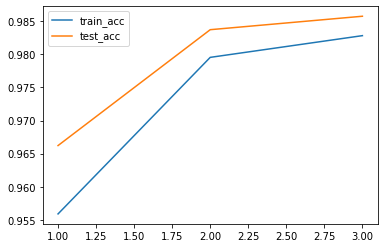

In [6]:

def training_epoch(model, dataloader, loss_fn, optimizer):
    total_loss, acc = 0,0
    data_size = len(dataloader.dataset)
    model.train()
    for (X,y) in dataloader:
        (X,y) = (X.to(device), y.to(device))
        out = model(X)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, y_pred = torch.max(out, dim=1)
        total_loss += loss_fn(out, y).item()
        acc += (y_pred == y).type(torch.float).sum().item()
    return total_loss/(data_size), acc/(data_size)

def valid_epoch(model, dataloader, loss_fn):
    data_size = len(dataloader.dataset)
    loss, acc = 0,0
    model.eval()
    for X,y in dataloader:
        X,y = X.to(device), y.to(device)
        out = model(X)
        _, y_pred = torch.max(out, dim=1)
        loss += loss_fn(out, y).item()
        acc += (y_pred == y).type(torch.float).sum().item()
        
    return loss/(data_size), acc/(data_size)

optimizer = torch.optim.Adam(new_net.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

train_hist = []
test_hist = []
for t in range(3):
    train_hist.append(training_epoch(new_net, training_dataloader, loss_fn, optimizer))
    with torch.no_grad():
        test_hist.append(valid_epoch(new_net, test_dataloader, loss_fn))

train_loss = [i[0] for i in train_hist]
train_acc = [i[1] for i in train_hist]
test_loss = [i[0] for i in test_hist]
test_acc = [i[1] for i in test_hist]

plt.figure()
plt.plot([x+1 for x in range(3)], train_acc)
plt.plot([x+1 for x in range(3)], test_acc)
plt.legend(['train_acc', 'test_acc'])
plt.show()
